# Experiments: IBM HR Analytics Employee Attrition

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
pd.options.display.max_columns = None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('./after_vis.csv')
df.head()

Attrition  MonthlyRate  Age  DailyRate  YearsAtCompany  TotalWorkingYears  \
0          1        19479   41       1102               6                  8   
1          0        24907   49        279              10                 10   
2          1         2396   37       1373               0                  7   
3          0        23159   33       1392               8                  8   
4          0        16632   27        591               2                  6   

   HourlyRate  DistanceFromHome  PercentSalaryHike  NumCompaniesWorked  \
0          94                 1                 11                   8   
1          61                 8                 23                   1   
2          92                 2                 15                   6   
3          56                 3                 11                   1   
4          40                 2                 12                   9   

   YearsInCurrentRole  TrainingTimesLastYear  EnvironmentSatisfaction  \
0                   4                      0                        2   
1                   7                      3                        3   
2                   0                      3                        4   
3                   7                      3                        4   
4                   2                      3                        1   

   YearsWithCurrManager  JobSatisfaction  EnvironmentSatisfaction.1  \
0                     5                4                          2   
1                     7                2                          3   
2                     0                3                          4   
3                     0                3                          4   
4                     2                2                          1   

   JobInvolvement  
0               3  
1               2  
2               2  
3               3  
4               3

### Scale the data

In [3]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled, columns=df.columns)

df_normalized.head()

Attrition  MonthlyRate       Age  DailyRate  YearsAtCompany  \
0        1.0     0.698053  0.547619   0.715820            0.15   
1        0.0     0.916001  0.738095   0.126700            0.25   
2        1.0     0.012126  0.452381   0.909807            0.00   
3        0.0     0.845814  0.357143   0.923407            0.20   
4        0.0     0.583738  0.214286   0.350036            0.05   

   TotalWorkingYears  HourlyRate  DistanceFromHome  PercentSalaryHike  \
0              0.200    0.914286          0.000000           0.000000   
1              0.250    0.442857          0.250000           0.857143   
2              0.175    0.885714          0.035714           0.285714   
3              0.200    0.371429          0.071429           0.000000   
4              0.150    0.142857          0.035714           0.071429   

   NumCompaniesWorked  YearsInCurrentRole  TrainingTimesLastYear  \
0            0.888889            0.222222                    0.0   
1            0.111111            0.388889                    0.5   
2            0.666667            0.000000                    0.5   
3            0.111111            0.388889                    0.5   
4            1.000000            0.111111                    0.5   

   EnvironmentSatisfaction  YearsWithCurrManager  JobSatisfaction  \
0                 0.333333              0.294118         1.000000   
1                 0.666667              0.411765         0.333333   
2                 1.000000              0.000000         0.666667   
3                 1.000000              0.000000         0.666667   
4                 0.000000              0.117647         0.333333   

   EnvironmentSatisfaction.1  JobInvolvement  
0                   0.333333        0.666667  
1                   0.666667        0.333333  
2                   1.000000        0.333333  
3                   1.000000        0.666667  
4                   0.000000        0.666667

### Split the data into training and test data

In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

X = df.drop(['Attrition'], axis=1)
y = df.Attrition

#Take only 8 most important features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_test.value_counts(normalize=True)

#Test data distribution

0    0.855967
1    0.144033
Name: Attrition, dtype: float64

### Helpers

In [5]:
from sklearn.metrics import recall_score, f1_score, roc_curve, roc_auc_score, precision_score, average_precision_score

def heatmap(y_test, predicted):
    cm = confusion_matrix(y_test, predicted)

    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();
    
def metrics(y_test, predicted, clf):
    average_precision = average_precision_score(y_test, predicted)

    print('Accuracy: %0.3f' %accuracy_score(y_test, predicted)) 
    print('Recall: %0.3f' % recall_score(y_test, predicted)) # tp / (tp + fn) 
    print('F1 score: %0.3f' % f1_score(y_test, predicted))
    print('Precision: %0.3f' % precision_score(y_test, predicted))
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print('AUC score: %0.3f' % auc)

    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## Classifiers

 - Choose metric (!) Acuracy is not so great here

#### Dummy classifier, all values No

In [6]:
acc = accuracy_score(y_test, np.zeros(486))
print("Dummy Accuracy: %0.4f " % acc)

Dummy Accuracy: 0.8560 


#### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight('balanced', np.unique(y_train), y_train)

# C - inverse of regularization,  smaller values specify stronger regularization.
# solvers - liblinear, newton-cg, lbfgs, sag and saga
clf = LogisticRegression(C=0.1, solver='liblinear', class_weight ='balanced') 

## Adjust hiperparameters based on this cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring = 'average_precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Precision: 0.37 (+/- 0.10)


In [8]:
clf.fit(X_train, y_train)
predicted =clf.predict(X_test) # Here we score Accuracy, not Precision as above!

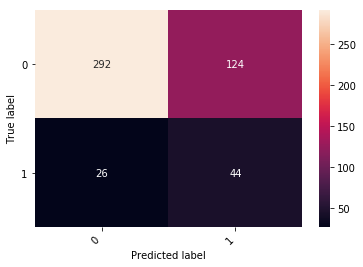

In [9]:
heatmap(y_test, predicted)

Accuracy: 0.691
Recall: 0.629
F1 score: 0.370
Precision: 0.262
Average precision-recall score: 0.218
AUC score: 0.686


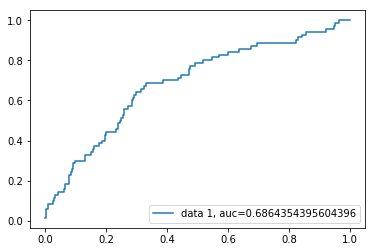

In [10]:
metrics(y_test, predicted, clf)

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=16, min_samples_split=5, 
                             min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                             max_features=None, random_state=None, max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, min_impurity_split=0.15, 
                             class_weight=None, presort=False)

scores = cross_val_score(dtree, X_train, y_train, scoring = 'precision', cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.28 (+/- 0.07)


In [12]:
#Once you are sure about them, train a model and check accuracy

dtree.fit(X_train, y_train)
predicted =dtree.predict(X_test)
acc = accuracy_score(y_test, predicted)
print("Classifier Accuracy: %0.4f " % acc)

##saying 'No' all the time would result with the same score!
acc = accuracy_score(y_test, np.zeros(486))
print("Dummy Accuracy: %0.4f " % acc)

#Predicting No all the time is simple! Time to deal with it.

Classifier Accuracy: 0.8169 
Dummy Accuracy: 0.8560 


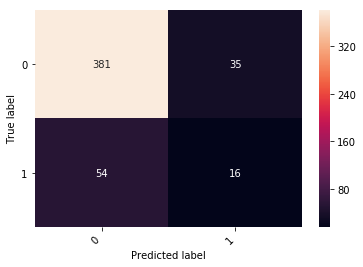

In [13]:
heatmap(y_test, predicted)

Accuracy: 0.817
Recall: 0.229
F1 score: 0.264
Precision: 0.314
Average precision-recall score: 0.183
AUC score: 0.509


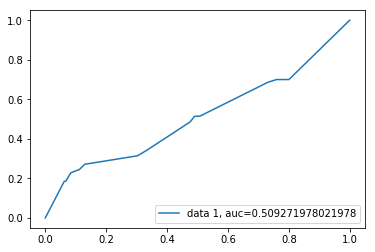

In [14]:
metrics(y_test, predicted, dtree)

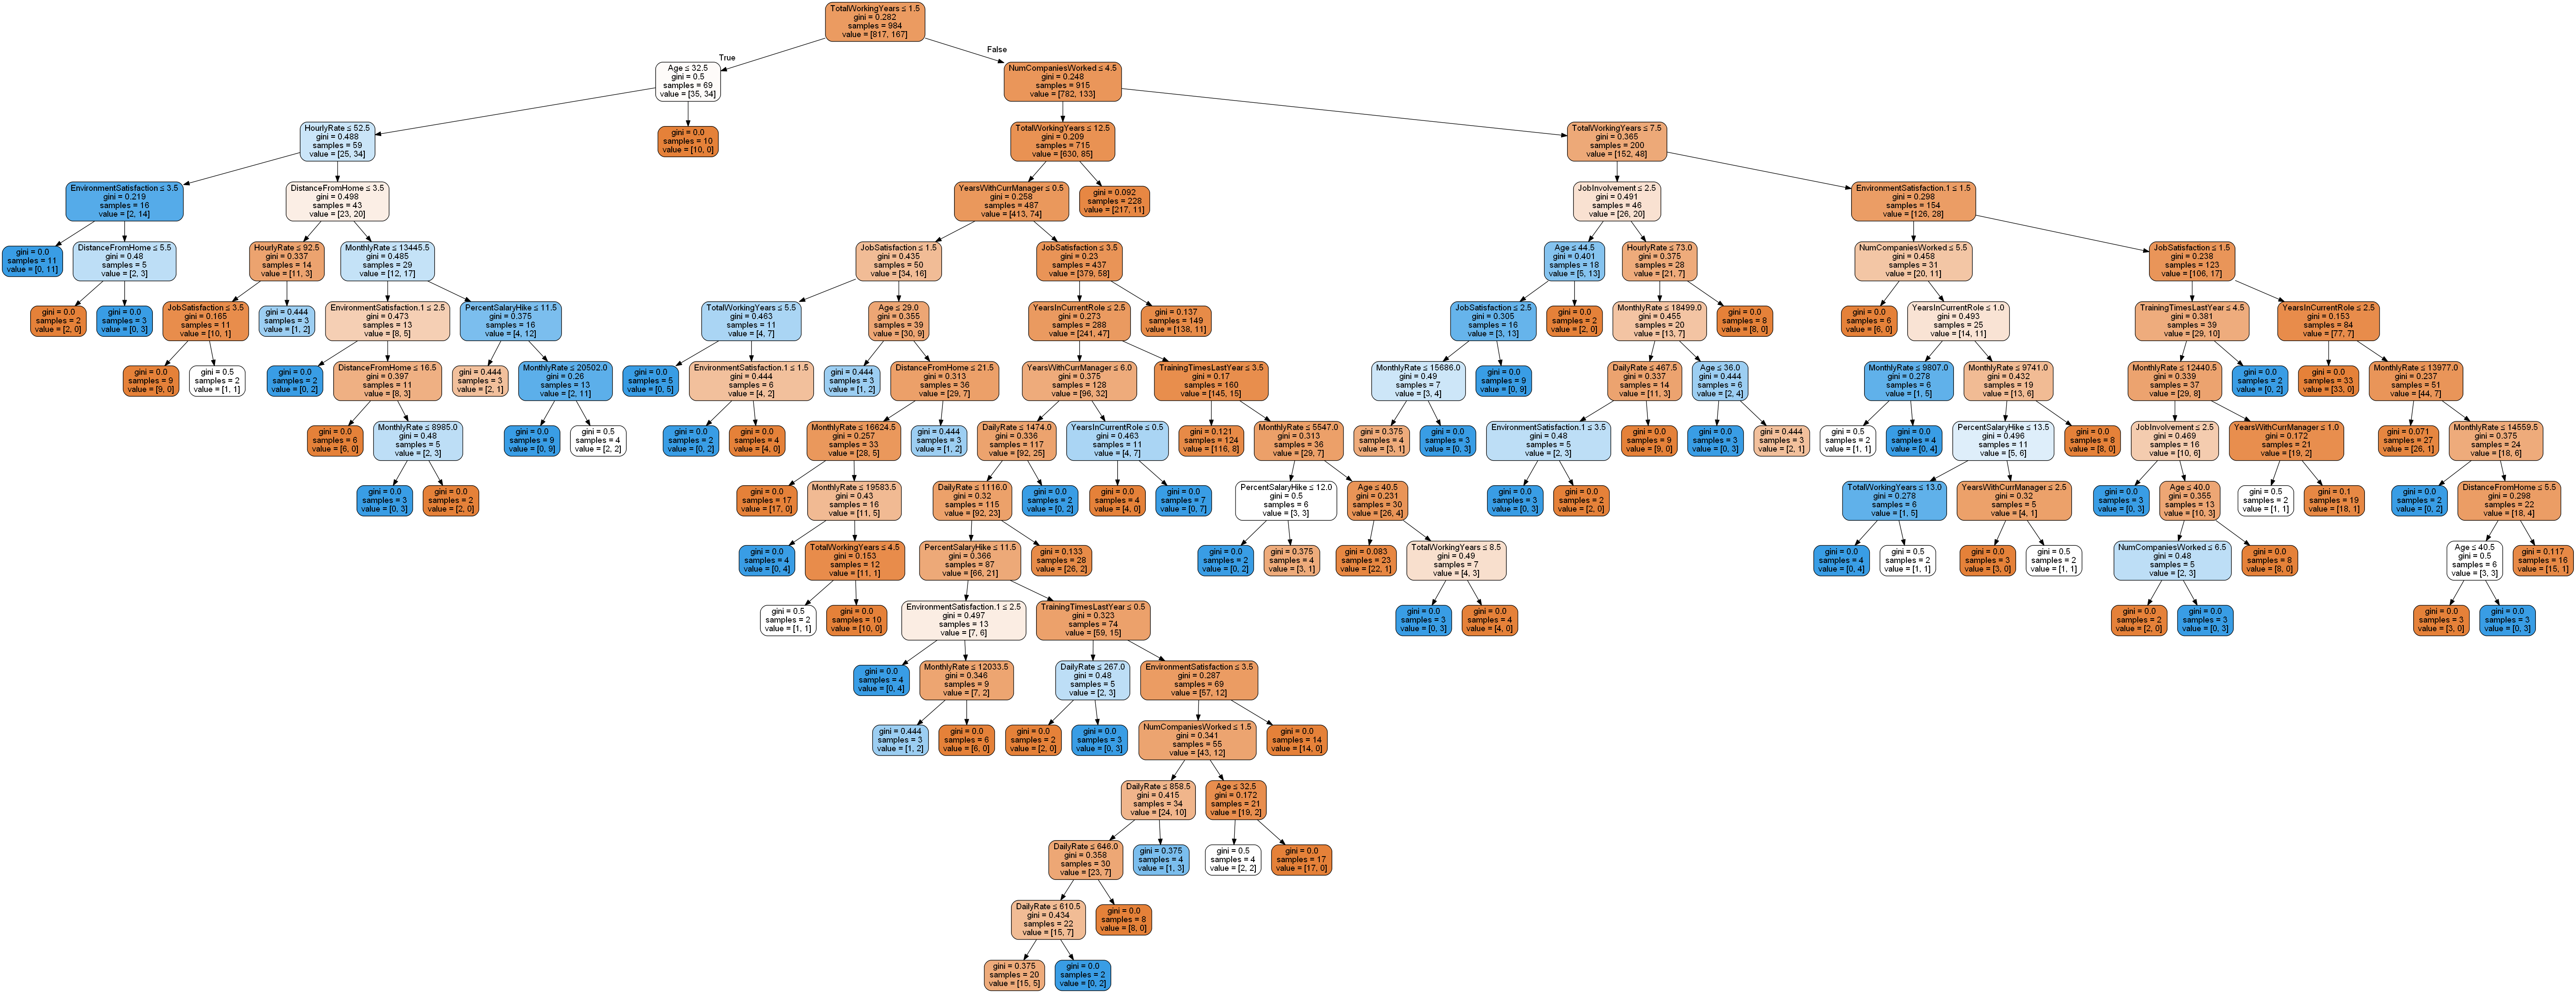

In [15]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [16]:
##Downloaded from: https://www.garysieling.com/blog/rending-scikit-decision-trees-d3-js

import sklearn 
def viz(decision_tree, feature_names=None):
  from warnings import warn
 
  js = ""
 
  def node_to_str(tree, node_id, criterion):
    if not isinstance(criterion, sklearn.tree.tree.six.string_types):
      criterion = "impurity"
 
    value = tree.value[node_id]
    if tree.n_outputs == 1:
      value = value[0, :]
 
    if tree.children_left[node_id] == sklearn.tree._tree.TREE_LEAF:
      return '{"id": "%s", "criterion": "%s", "impurity": "%s", "samples": "%s", "value": "%s"}' \
             % (node_id, 
                criterion,
                tree.impurity[node_id],
                tree.n_node_samples[node_id],
                value)
    else:
      if feature_names is not None:
        feature = feature_names[tree.feature[node_id]]
      else:
        feature = tree.feature[node_id]
 
      return '"id": "%s", "rule": "%s <= %.4f", "%s": "%s", "samples": "%s"' \
             % (node_id, 
                feature,
                tree.threshold[node_id],
                criterion,
                tree.impurity[node_id],
                tree.n_node_samples[node_id])
 
  def recurse(tree, node_id, criterion, parent=None, depth=0):
    tabs = "  " * depth
    js = ""
 
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]
 
    js = js + "\n" + \
         tabs + "{\n" + \
         tabs + "  " + node_to_str(tree, node_id, criterion)
 
    if left_child != sklearn.tree._tree.TREE_LEAF and depth < 6:
      js = js + ",\n" + \
           tabs + '  "left": ' + \
           recurse(tree, \
                   left_child, \
                   criterion=criterion, \
                   parent=node_id, \
                   depth=depth + 1) + ",\n" + \
           tabs + '  "right": ' + \
           recurse(tree, \
                   right_child, \
                   criterion=criterion, \
                   parent=node_id,
                   depth=depth + 1)
 
    js = js + tabs + "\n" + \
         tabs + "}"
 
    return js
 
  if isinstance(decision_tree, sklearn.tree.tree.Tree):
    js = js + recurse(decision_tree, 0, criterion="impurity")
  else:
    js = js + recurse(decision_tree.tree_, 0, criterion=decision_tree.criterion)
 
  return js


 
print (viz(dtree, df.columns))


{
  "id": "0", "rule": "YearsAtCompany <= 1.5000", "gini": "0.2818242283032586", "samples": "984",
  "left": 
  {
    "id": "1", "rule": "MonthlyRate <= 32.5000", "gini": "0.4998949800462088", "samples": "69",
    "left": 
    {
      "id": "2", "rule": "TotalWorkingYears <= 52.5000", "gini": "0.4883654122378627", "samples": "59",
      "left": 
      {
        "id": "3", "rule": "TrainingTimesLastYear <= 3.5000", "gini": "0.21875", "samples": "16",
        "left": 
        {
          {"id": "4", "criterion": "gini", "impurity": "0.0", "samples": "11", "value": "[ 0. 11.]"}        
        },
        "right": 
        {
          "id": "5", "rule": "HourlyRate <= 5.5000", "gini": "0.48", "samples": "5",
          "left": 
          {
            {"id": "6", "criterion": "gini", "impurity": "0.0", "samples": "2", "value": "[2. 0.]"}          
          },
          "right": 
          {
            {"id": "7", "criterion": "gini", "impurity": "0.0", "samples": "3", "value": "[0. 3.]"}

## SVM: NEED ATTENTION!

In [17]:
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

clf = svm.SVC(kernel='rbf', C=1000, probability=True, class_weight={0: 0.6, 1:2.94}) 
#kernel: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#class_weight: auto, balanced, 
scores = cross_val_score(clf, X_train, y_train, scoring = 'precision', cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.00 (+/- 0.00)


In [18]:
#Once you are sure about them, train a model and check accuracy

clf.fit(X_train, y_train)
predicted =clf.predict(X_test)
acc = accuracy_score(y_test, predicted)
print("True Accuracy: %0.4f " % acc)

##saying 'No' all the time would result with the same score!
acc = accuracy_score(y_test, np.zeros(486))
print("Dummy Accuracy: %0.4f " % acc)

#Predicting No all the time is simple! Time to deal with it.

True Accuracy: 0.8560 
Dummy Accuracy: 0.8560 


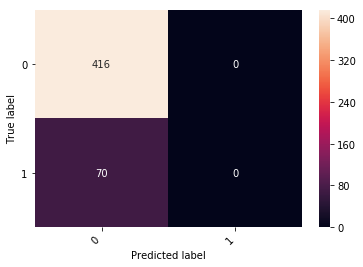

In [19]:
heatmap(y_test, predicted)

Accuracy: 0.856
Recall: 0.000
F1 score: 0.000
Precision: 0.000
Average precision-recall score: 0.144
AUC score: 0.499


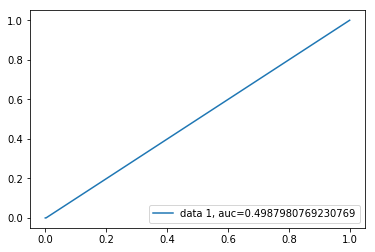

In [20]:
metrics(y_test, predicted, clf)

### Random Forest

In [21]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rfc = RandomForestClassifier()
scores = cross_val_score(rfc, X_train, y_train, cv=3)## Adjust hiperparameters based on this data
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.01)


In [22]:
#Once you are sure about them, train a model and check accuracy
rfc.fit(X_train, y_train)
predicted =rfc.predict(X_test)
acc = accuracy_score(y_test, predicted)
print("True Accuracy: %0.4f " % acc)

True Accuracy: 0.8436 


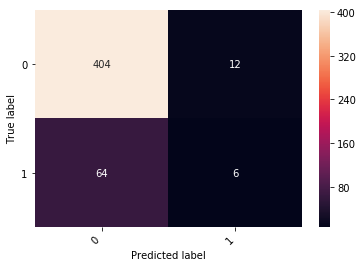

In [23]:
heatmap(y_test, predicted)

Accuracy: 0.844
Recall: 0.086
F1 score: 0.136
Precision: 0.333
Average precision-recall score: 0.160
AUC score: 0.607


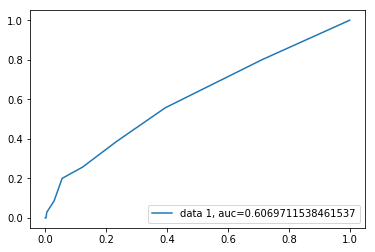

In [24]:
metrics(y_test, predicted, rfc)

### Neural Network: NEED ATTENTION!

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras_metrics

# create model
model = Sequential()
model.add(Dense(22, input_dim=16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(lr=0.2), 
              loss='binary_crossentropy', 
              metrics=[keras_metrics.precision(), keras_metrics.recall()])

model.fit(X_train, y_train, epochs=30, batch_size=30)

scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

predicted= model.predict_classes(X_test)

Using TensorFlow backend.


Epoch 1/30
984/984 [==============================] - 0s 207us/step - loss: 2.8182 - precision: 0.0087 - recall: 0.0122  
Epoch 2/30
984/984 [==============================] - 0s 22us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/30
984/984 [==============================] - 0s 19us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/30
984/984 [==============================] - 0s 18us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/30
984/984 [==============================] - 0s 20us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/30
984/984 [==============================] - 0s 20us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/30
984/984 [==============================] - 0s 20us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/30
984/984 [==============================] - 0s 22us/step - loss: 2.7355 - precision: 0.0000e+00 - recall: 

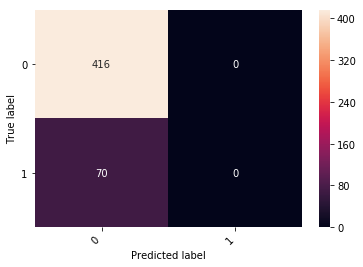

In [26]:
heatmap(y_test, predicted)

Accuracy: 0.856
Recall: 0.000
F1 score: 0.000
Precision: 0.000
Average precision-recall score: 0.144
AUC score: 0.500


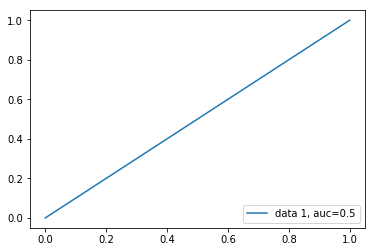

In [27]:
average_precision = average_precision_score(y_test, predicted)

print('Accuracy: %0.3f' %accuracy_score(y_test, predicted)) 
print('Recall: %0.3f' % recall_score(y_test, predicted)) # tp / (tp + fn) 
print('F1 score: %0.3f' % f1_score(y_test, predicted))
print('Precision: %0.3f' % precision_score(y_test, predicted))
print('Average precision-recall score: {0:0.3f}'.format(average_precision))

y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC score: %0.3f' % auc)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### LightGMB

In [28]:
import lightgbm as lgb

#### Search for optimal parameters

In [30]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

estimator = lgb.LGBMClassifier(class_weight='balanced')

param_grid = {
    'learning_rate': [0.01, 0.1, 1 ],
    'n_estimators': [60, 100, 150],
    'num_leaves': [20, 31, 35],
    'reg_lambda': [0, 0.1, 0.2],
    'colsample_bytree': [1, 0.9, 0.8]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'n_estimators': 150, 'learning_rate': 0.1, 'reg_lambda': 0, 'num_leaves': 31, 'colsample_bytree': 0.9}


In [31]:
gbm = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=150, 
    subsample_for_bin=200000, 
    objective='binary', 
    class_weight='balanced', 
    min_split_gain=0.0, 
    min_child_weight=0.1, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=1, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.1, 
    random_state=None, 
    n_jobs=-1, 
    silent=True)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1', # binary_logloss
        early_stopping_rounds=5,
        verbose=False)

print('Start predicting...')

# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('\n\nAccuracy: %0.3f' %accuracy_score(y_test, y_pred)) 

print('\nFeature importances:', list(gbm.feature_importances_))

Start predicting...


Accuracy: 0.840

Feature importances: [589, 430, 645, 177, 267, 547, 364, 283, 155, 160, 200, 195, 169, 151, 0, 138]


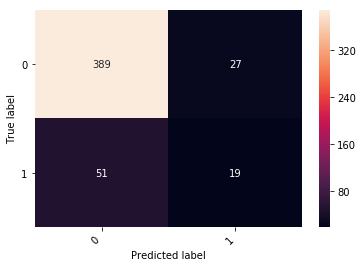

In [32]:
heatmap(y_test, y_pred)

#### Search for optimal parameters

In [33]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (roc_curve, auc, accuracy_score)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': None,
    'metric': {'binary_logloss', 'auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, verbose=False)

# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval)

gridParams = {
    'learning_rate': [0.01, 0.1, 1 ],
    'n_estimators': [60, 100, 150],
    'num_leaves': [20, 31, 35],
    'reg_lambda': [0, 0.1, 0.2],
    'colsample_bytree': [1, 0.9, 0.8],
    'min_split_gain': [0, 0.1, 0.2],
    'min_child_weight': [0.001, 0.01, 0.1]
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

scoring = {'AUC': 'roc_auc'}

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, scoring=scoring, n_jobs=-1, refit='AUC')
# Run the grid
grid.fit(X_train, y_train, verbose=False)

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)
grid.best_estimator_

[1]	valid_0's auc: 0.610234	valid_0's binary_logloss: 0.410315
[2]	valid_0's auc: 0.623661	valid_0's binary_logloss: 0.406322
[3]	valid_0's auc: 0.646909	valid_0's binary_logloss: 0.401714
[4]	valid_0's auc: 0.645501	valid_0's binary_logloss: 0.399068
[5]	valid_0's auc: 0.648043	valid_0's binary_logloss: 0.396224
[6]	valid_0's auc: 0.64181	valid_0's binary_logloss: 0.395609
[7]	valid_0's auc: 0.64545	valid_0's binary_logloss: 0.394037
[8]	valid_0's auc: 0.652953	valid_0's binary_logloss: 0.392203
[9]	valid_0's auc: 0.649159	valid_0's binary_logloss: 0.392299
[10]	valid_0's auc: 0.651425	valid_0's binary_logloss: 0.39173
[11]	valid_0's auc: 0.65874	valid_0's binary_logloss: 0.390374
[12]	valid_0's auc: 0.664921	valid_0's binary_logloss: 0.38978
[13]	valid_0's auc: 0.670192	valid_0's binary_logloss: 0.389333
[14]	valid_0's auc: 0.667617	valid_0's binary_logloss: 0.390301
[15]	valid_0's auc: 0.66784	valid_0's binary_logloss: 0.389189
[16]	valid_0's auc: 0.668922	valid_0's binary_logloss: 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4058 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5596 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7298 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9160 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10920 out of 10935 | elapsed:  3.9min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  3.9min finished


Best parameters found by grid search are: {'n_estimators': 60, 'reg_lambda': 0.1, 'min_split_gain': 0.1, 'learning_rate': 0.1, 'min_child_weight': 0.001, 'num_leaves': 20, 'colsample_bytree': 1}
Best score found by grid search is: 0.6976057589929411


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1, feature_fraction=0.8,
        is_enable_sparse=True, is_save_binary_file=False,
        is_training_metric=True, learning_rate=0.1, max_bin=255,
        max_depth=-1, metric={'auc', 'binary_logloss'}, metric_freq=1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=50,
        min_split_gain=0.1, min_sum_hessian_in_leaf=5, n_estimators=60,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, task='train',
        tree_learner='serial', use_two_round_loading=False)

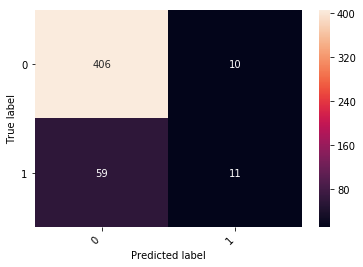

In [37]:
y_pred = grid.best_estimator_.predict(X_test)
heatmap(y_test, y_pred)

## Hyperopt
You can try to use Hyperopt for better performance

## Addressing imbalance data

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

Common techniques:
 - Changing Your Performance Metric (precision, recall and so on...)
 - Class weight
 - Over-sampling: generate new samples in the classes which are under-represented. 
     - Random
     - SMOTE: Synthetic Minority Oversampling Technique
     - ADASYN: Adaptive Synthetic
 - Under-sampling
 - Combination of over- and under-sampling
 - Ensemble of samplers

### Ensemble (at the end)

 - bagging
 - stacking
 - averaging